In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from graphviz import Digraph, Source
from scipy.integrate import odeint



import os  
%matplotlib inline

# Моделі масового обслуговування з чергою

In [3]:
#16 варiант
lamda = 1.74
mu = 2.2
r = 2
m = 4

### Граф станів

[2.2, 4.4, 4.4, 4.4, 4.4, 4.4]
[2.2 4.4 4.4 4.4 4.4 4.4]


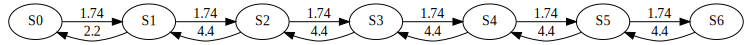

In [6]:
dot = Digraph()

for i in range(r+m+1):
    dot.node('S'+str(i))
    
mu_list = []

for i in range(r+m):
    if i < r:
        mu_list.append(mu*(i+1))
        dot.edge('S'+str(i+1), 'S'+str(i), label=str(mu_list[i]))
        dot.edge('S'+str(i), 'S'+str(i+1), label=str(lamda))
    else:
        mu_list.append(mu*r)
        dot.edge('S'+str(i+1), 'S'+str(i), label=str(mu*r))
        dot.edge('S'+str(i), 'S'+str(i+1), label=str(lamda))
print(mu_list)
mu_arr = np.array(mu_list)
print(mu_arr)
dot.graph_attr['rankdir'] = 'LR'
Source.from_file('Graph.gv')

### Cистема алгебраїчних рівнянь, складена відносно стаціонарних ймовірностей

In [7]:
A = np.zeros((m+r+1, m+r+1))
b = np.zeros(m+r+1)
b[m+r] = 1
k = 0
for i in range(m+r+1):
    if i == 0:
        A[i][k] = -lamda
        A[i][k+1] = mu_arr[i]
        k += 1
    elif i < m+r:
        A[i][k-1] = lamda
        A[i][k] = -(lamda + mu_arr[i-1])
        A[i][k+1] = mu_arr[i]
        k += 1
    else:
        A[i] = np.ones(m+r+1)

string = 'A = {}\n\nb = {}'.format(A, np.array([b]).T)
print(string)

A = [[-1.74  2.2   0.    0.    0.    0.    0.  ]
 [ 1.74 -3.94  4.4   0.    0.    0.    0.  ]
 [ 0.    1.74 -6.14  4.4   0.    0.    0.  ]
 [ 0.    0.    1.74 -6.14  4.4   0.    0.  ]
 [ 0.    0.    0.    1.74 -6.14  4.4   0.  ]
 [ 0.    0.    0.    0.    1.74 -6.14  4.4 ]
 [ 1.    1.    1.    1.    1.    1.    1.  ]]

b = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


### Розв'язання системи

In [8]:
p = np.linalg.solve(A, b)

frame = pd.DataFrame({'Розв\'язок': [np.array2string(p[0], precision=8)]}, index=['p_0'])
for i in range(1, r+m+1):
    frame = frame.append(pd.DataFrame({'Розв\'язок': [np.array2string(p[i], precision=8)]}, index=['p_'+str(i)]))
    
frame

,Розв'язок
p_0,0.43416588
p_1,0.34338574
p_2,0.13579345
p_3,0.05370014
p_4,0.02123596
p_5,0.00839786
p_6,0.00332097


### Розрахунок стаціонарних характеристик роботи системи

In [9]:
M_X = 0
for i in range(r+m+1):
    if i < r:
        M_X += i*p[i]
    else:
        M_X += r*p[i]
        
K_z = M_X/r

M_Y = 0
for i in range(1, r+1):
    M_Y += i*p[r-i]
    
K_p = M_Y/r

In [10]:
pd.DataFrame({'Показник': [M_X, K_z, M_Y, K_p]},
             index=['Середнє число каналів, зайнятих обслуговуванням заявок',
                    'Коефіцієнт завантаженості',
                    'Середнє число каналів, вільних від обслуговування заявок',
                    'Коефіцієнт простою'])

,Показник
"Середнє число каналів, зайнятих обслуговуванням заявок",0.788283
Коефіцієнт завантаженості,0.394141
"Середнє число каналів, вільних від обслуговування заявок",1.211717
Коефіцієнт простою,0.605859


### Система диференціальних рівнянь Колмогорова, невідомими якої є ймовірності станів, що залежать від часу

In [11]:
def system(P, t, lamda, mu_arr):
    dpdt = []
    for i in range(r+m+1):
        if i == 0:
            dpdt.append(-lamda*P[i] + mu_arr[i]*P[i+1])
        elif i < r+m:
            dpdt.append(lamda*P[i-1] - (lamda + mu_arr[i-1])*P[i] + mu_arr[i]*P[i+1])
        else:
            dpdt.append(lamda*P[i-1] - mu_arr[i-1]*P[i])
            
    return dpdt

### Розв'язок системи

In [12]:
p0 = [1,0,0,0,0,0,0]
t = np.linspace(0, 10, 1001)  # Моменти часу: 0, 1, 2, 3, ..., 9, 10 одиниць часу
p_t = odeint(system, p0, t, args=(lamda, mu_arr,))

p = []
for i in range(r+m+1):
    p.append(p_t[:,i])

d = {}

for i in range(r+m+1):
    d['p_'+str(i)+' (t)'] = {}
    for j in range(11):
        d['p_'+str(i)+' (t)']['t='+str(int(t[j*100]))] = p[i][j*100]
        
pd.DataFrame.from_dict(d, orient='index')

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,t=10
p_0 (t),1.0,0.492280,0.446759,0.437658,0.435209,0.434484,0.434263,0.434196,0.434175,0.434169,0.434167
p_1 (t),0.0,0.342597,0.345557,0.344195,0.343645,0.343466,0.343411,0.343393,0.343388,0.343386,0.343386
p_2 (t),0.0,0.116406,0.132378,0.134934,0.135544,0.135718,0.135770,0.135786,0.135791,0.135793,0.135793
p_3 (t),0.0,0.035750,0.049251,0.052432,0.053319,0.053584,0.053664,0.053689,0.053697,0.053699,0.053700
p_4 (t),0.0,0.009873,0.017701,0.020157,0.020905,0.021134,0.021205,0.021226,0.021233,0.021235,0.021236
p_5 (t),0.0,0.002477,0.006180,0.007684,0.008176,0.008330,0.008377,0.008391,0.008396,0.008397,0.008398
p_6 (t),0.0,0.000617,0.002175,0.002940,0.003201,0.003284,0.003310,0.003317,0.003320,0.003321,0.003321


### Розрахунок нестаціонарних характеристик роботи системи

In [13]:
M_X = np.zeros(t.shape[0])
for i in range(t.shape[0]):
    for j in range(r+m+1):
        if j < r:
            M_X[i] += j*p[j][i]
        else:
            M_X[i] += r*p[j][i]
        
K_z = M_X/r

M_Y = np.zeros(t.shape[0])
for i in range(t.shape[0]):
    for j in range(1, r+1):
        M_Y[i] += j*p[r-j][i]
    
K_p = M_Y/r

In [14]:
d = {
     'Середнє число каналів, зайнятих обслуговуванням заявок': {},
     'Коефіцієнт завантаженості': {},
     'Середнє число каналів, вільних від обслуговування заявок': {},
     'Коефіцієнт простою': {}
    }

for j in range(11):
    d['Середнє число каналів, зайнятих обслуговуванням заявок']['t='+str(int(t[j*100]))] = M_X[j*100]
    d['Коефіцієнт завантаженості']['t='+str(int(t[j*100]))] = K_z[j*100]
    d['Середнє число каналів, вільних від обслуговування заявок']['t='+str(int(t[j*100]))] = M_Y[j*100]
    d['Коефіцієнт простою']['t='+str(int(t[j*100]))] = K_p[j*100]

pd.DataFrame.from_dict(d, orient='index')

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,t=10
"Середнє число каналів, зайнятих обслуговуванням заявок",0.0,0.672842,0.760926,0.780489,0.785937,0.787566,0.788063,0.788215,0.788262,0.788276,0.788281
Коефіцієнт завантаженості,0.0,0.336421,0.380463,0.390244,0.392968,0.393783,0.394031,0.394108,0.394131,0.394138,0.394140
"Середнє число каналів, вільних від обслуговування заявок",2.0,1.327158,1.239074,1.219511,1.214063,1.212434,1.211937,1.211785,1.211738,1.211724,1.211719
Коефіцієнт простою,1.0,0.663579,0.619537,0.609756,0.607032,0.606217,0.605969,0.605892,0.605869,0.605862,0.605860


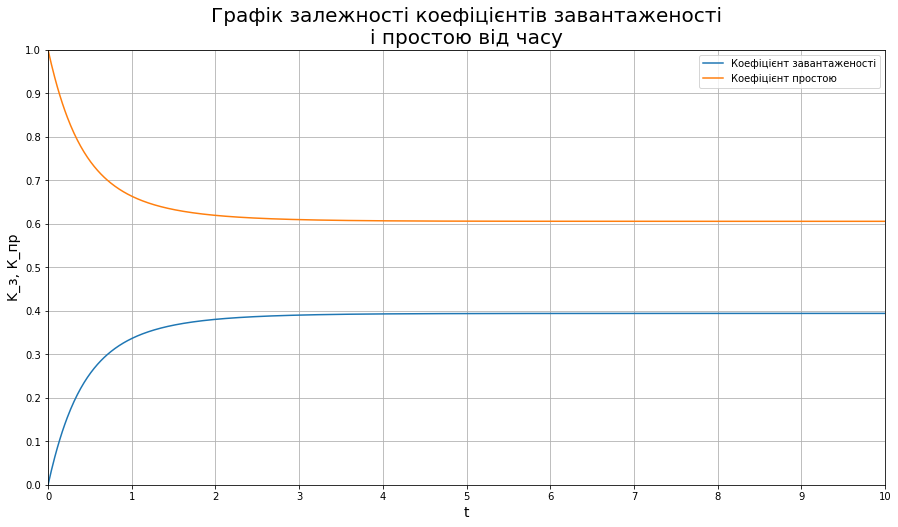

In [15]:
plt.figure(figsize=(15,8))
plt.title('Графік залежності коефіцієнтів завантаженості\nі простою від часу', fontsize=20)
plt.xlabel('t', fontsize=14)
plt.ylabel('K_з, К_пр', fontsize=14)
plt.xticks(np.linspace(0, 10, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
plt.plot(t, K_z, label='Коефіцієнт завантаженості')
plt.plot(t, K_p, label='Коефіцієнт простою')
plt.legend()
plt.axis([0, 10, 0, 1])
plt.show()

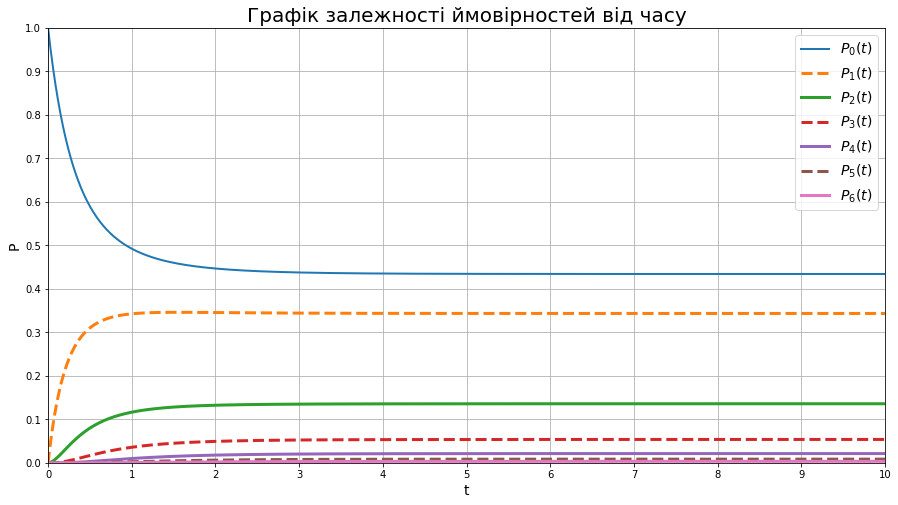

In [16]:
plt.figure(figsize=(15,8))
plt.title('Графік залежності ймовірностей від часу', fontsize=20)
plt.xlabel('t', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.xticks(np.linspace(0, 10, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
s = ['-', '--', '-', '--', '-', '--', '-']
linewidth = [2, 3, 3, 3, 3, 3, 3]
for i in range(r+m+1):
    plt.plot(t, p_t[:,i], s[i], label='$P_'+str(i)+'(t)$', linewidth=linewidth[i])
plt.legend(fontsize=14)
plt.axis([0, 10, 0, 1])
plt.show()